In [1]:
import numpy as np
import pandas as pd

Reading raw data

In [ ]:
items = pd.read_csv('items.csv')
sample_submission=pd.read_csv('../input/sample_submission.csv.gz',compression='gzip')
item_categories = pd.read_csv('item_categories.csv')
parser = lambda date: pd.to_datetime(date, format='%d.%m.%Y')
sales_train = pd.read_csv('../input/sales_train.csv.gz',compression='gzip', parse_dates=['date'], date_parser=parser)
shops = pd.read_csv('shops.csv')
test=pd.read_csv('../input/test.csv.gz',compression='gzip')

Check the shape and the columns of the data :

In [5]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [6]:
items.shape

(22170, 3)

In [7]:
print("Number of items:",items['item_id'].nunique())
print("Number of categories:",items['item_category_id'].nunique())

Number of items: 22170
Number of categories: 84


In [8]:
item_categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [9]:
item_categories.shape

(84, 2)

In [10]:
item_categories['item_category_id'].nunique()

84

In [11]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [12]:
print("Number of shops:",shops['shop_id'].nunique())

Number of shops: 60


In [13]:
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
2,2013-01-05,0,25,2552,899.00,-1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0


In [14]:
sales_train.shape

(2935849, 6)

Creating date features

In [15]:
sales_train['month'] = sales_train['date'].dt.month
sales_train['year'] = sales_train['date'].dt.year
sales_train['weekday'] = sales_train['date'].dt.dayofweek
sales_train.drop('date', axis = 1, inplace = True)

In [16]:
sample_submission.head()

,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5


Submissions are evaluated by root mean squared error (RMSE). True target values are clipped into [0,20] range.

In [17]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [18]:
test.shape

(214200, 3)

In [19]:
sales_train[['date_block_num', 'month', 'year']].drop_duplicates()

,date_block_num,month,year
0,0,1,2013
115690,1,2,2013
224303,2,3,2013
345650,3,4,2013
439759,4,5,2013
531518,5,6,2013
631921,6,7,2013
732469,7,8,2013
837241,8,9,2013
933378,9,10,2013


As the object is to predict the count of selled items per shop for the month of november 2015, and since the disposed training
data is the count of selled items per shop from january 2013 to October 2015, thus this problem can be modeled as a time series problem.

Large conclusion item_category_name in item_categories and shop_name in shps must be traduced to english

In [20]:
import cyrtranslit
item_categories['item_category_name_latin'] = item_categories['item_category_name'].apply(lambda x: cyrtranslit.to_latin(x, 'ru'))

item_categories['item_category_name_latin'].nunique()
item_categories['item_category_name_latin'].unique()

#It's clear that there's subtypes of items, We will split item_categories['item_category_name_latin']
item_categories['category_main'] = item_categories['item_category_name_latin'].apply(lambda x: x.split('-')[0])
item_categories['category_sub'] = item_categories['item_category_name_latin'].apply(lambda x: x.split('-')[1] if '-' in x else x)
print("Number of main categories:",item_categories['category_main'].nunique())
print("Value counts of main categories:",item_categories['category_main'].value_counts())
print("Number of sub categories:",item_categories['category_sub'].nunique())

Number of main categories: 21
Value counts of main categories: Knigi                                13
Podarki                              12
Igrovye konsoli                       8
Igry                                  8
Aksessuary                            7
Programmy                             6
Muzyka                                6
Kino                                  5
Igry PC                               4
Karty oplaty                          4
Sluzhebnye                            1
Karty oplaty (Kino, Muzyka, Igry)     1
Sluzhebnye                            1
Bilety (Cifra)                        1
EHlementy pitanija                    1
PC                                    1
CHistye nositeli (shpil')             1
Dostavka tovara                       1
CHistye nositeli (shtuchnye)          1
Igry MAC                              1
Igry Android                          1
Name: category_main, dtype: int64
Number of sub categories: 65


Same loic for shops
After a google search, words outside the quotation mark are names of cities in Russia there's no need to translate them
After translating these words, we conclude that the first word is the city but the second and third words like ТРЦ, Сити-Парк represents general places like shopping center, park or mall
Only the city name will be taken into consideration

In [21]:
shops["shop_city"] = shops["shop_name"].apply(lambda x: x.split()[0])
print("Number of cities:",shops["shop_city"].nunique())

Number of cities: 32


We will proceed to label encoding

In [22]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
item_categories["category_main_label"] = labelencoder.fit_transform(item_categories["category_main"])
item_categories["category_sub_label"] = labelencoder.fit_transform(item_categories["category_sub"])
shops["shop_city_code"] = labelencoder.fit_transform(shops["shop_city"])
shops.drop(['shop_name', 'shop_city'], axis = 1, inplace = True)
item_categories.drop(['item_category_name', 'item_category_name_latin', 'category_main', 'category_sub'], axis = 1, inplace = True)

Replacing in other dataframes

In [23]:
items = items.merge(item_categories, on = 'item_category_id', how = 'left')
items.drop(['item_name'], axis = 1, inplace = True)
sales_train = sales_train.merge(items, on = 'item_id', how = 'left')
sales_train = sales_train.merge(shops, on = 'shop_id', how = 'left')

Data Viz

In [24]:
sales_train.date_block_num.plot()

The data is almost uniformly distributed with respect to the date_block_num

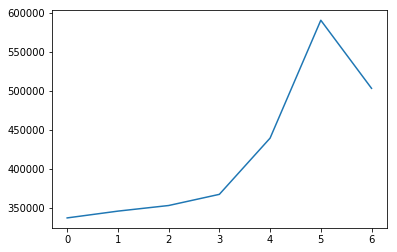

In [25]:
sales_train.weekday.value_counts().sort_index().plot()

On weekends there are more items sold than on week
This is only a presentation of the transactions, let's calculate the sum of the items sold and the income generated

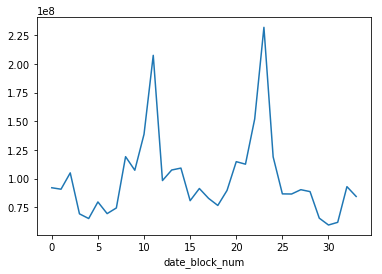

In [26]:
sales_train["revenue"] = sales_train["item_price"]*sales_train["item_cnt_day"]
sales_train.groupby("date_block_num")["revenue"].sum().plot()

During the Christmas period the income is utmost

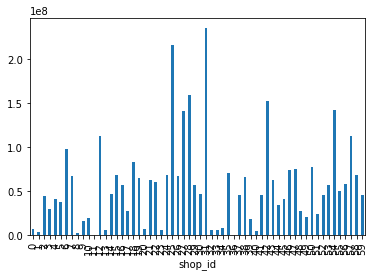

In [27]:
sales_train.groupby("shop_id")["revenue"].sum().plot.bar()

In [28]:
sales_train.groupby("shop_id")["revenue"].sum().sort_values(ascending = False)

shop_id
31    2.352170e+08
25    2.164806e+08
28    1.597463e+08
42    1.519170e+08
54    1.419397e+08
27    1.406325e+08
57    1.129998e+08
12    1.122051e+08
6     9.806745e+07
18    8.339270e+07
50    7.795060e+07
47    7.488210e+07
46    7.418932e+07
35    7.020477e+07
24    6.881169e+07
58    6.873762e+07
15    6.871037e+07
26    6.755109e+07
7     6.695766e+07
38    6.576643e+07
19    6.495392e+07
21    6.258139e+07
43    6.221770e+07
22    6.043889e+07
56    5.860590e+07
16    5.743649e+07
29    5.655014e+07
53    5.651104e+07
55    4.979206e+07
14    4.673728e+07
30    4.670246e+07
41    4.609299e+07
37    4.597469e+07
59    4.522658e+07
52    4.505424e+07
2     4.404964e+07
45    4.092480e+07
4     4.053965e+07
5     3.816043e+07
44    3.420403e+07
3     3.014085e+07
17    2.778495e+07
48    2.771411e+07
51    2.420516e+07
49    2.014092e+07
10    1.941028e+07
39    1.809289e+07
9     1.637284e+07
34    8.582822e+06
0     6.637370e+06
20    6.599924e+06
13    6.006173e+06
33  

In [29]:
sales_train["revenue"].describe()

count    2.935849e+06
mean     1.157732e+03
std      5.683604e+03
min     -6.897000e+04
25%      2.490000e+02
50%      4.490000e+02
75%      1.078200e+03
max      1.829990e+06
Name: revenue, dtype: float64

In [30]:
sales_train[sales_train["shop_id"]==31]["revenue"].describe()

count    2.356360e+05
mean     9.982219e+02
std      5.369954e+03
min     -2.799000e+04
25%      1.990000e+02
50%      3.990000e+02
75%      8.990000e+02
max      1.642100e+06
Name: revenue, dtype: float64

In [31]:
sales_train.loc[(sales_train["shop_id"]==31) & (sales_train['revenue']<1000), 'revenue'].describe()

count    184885.000000
mean        373.130588
std         265.431378
min      -27990.000000
25%         199.000000
50%         299.000000
75%         499.000000
max         999.500000
Name: revenue, dtype: float64

By removing transactions that have income greater than 1000 we end up with a descriptive statistic almost equal to the general
We will consider these transactions as outliers when training the model

Data viz for date_block_num

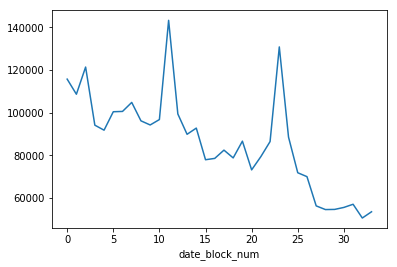

In [32]:
sales_train.groupby(["date_block_num"]).count().revenue.plot()

The number of transactions is decreasing, but as we have seen in the graph of revenue versus time, it is almost stationary. This means that the average price increases over time.

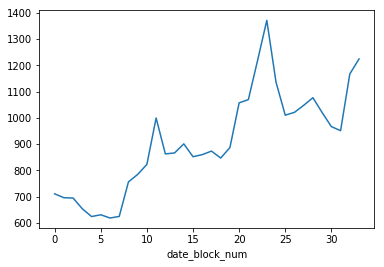

In [33]:
sales_train.groupby(["date_block_num"]).item_price.mean().plot()

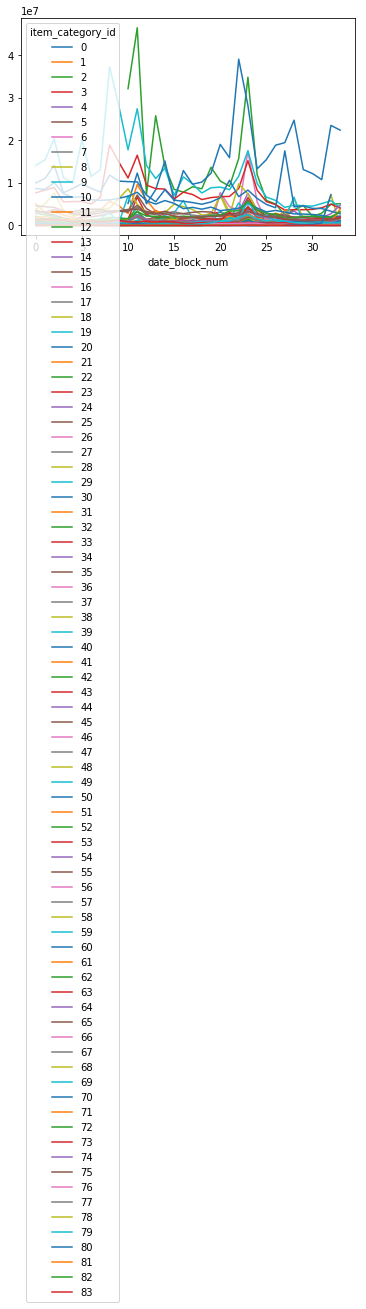

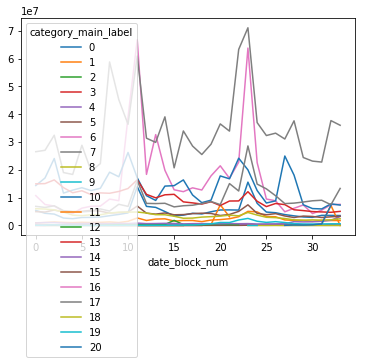

In [34]:
sales_train.groupby(["date_block_num","item_category_id"]).sum()["revenue"].unstack().plot()
sales_train.groupby(["date_block_num","category_main_label"]).sum()["revenue"].unstack().plot()

These two  graphs show that there are categories that are more sold during Christmas time. The tendency in general is like we said the pikes arrive during Christmas

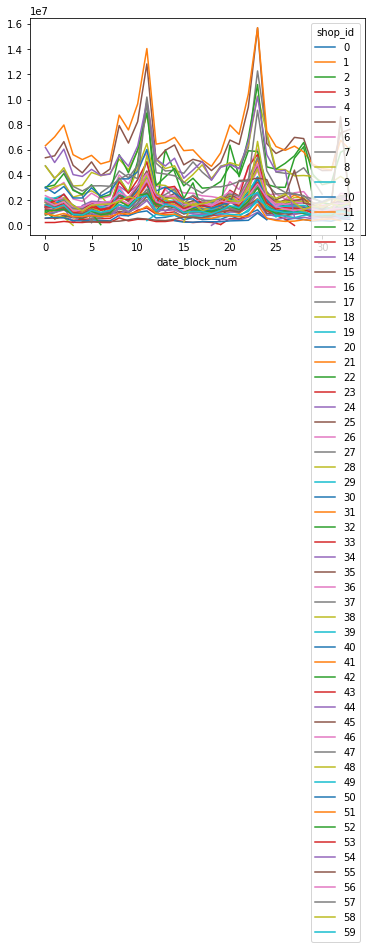

In [35]:
sales_train.groupby(["date_block_num","shop_id"]).sum()["revenue"].unstack().plot()

An interesting remarque is that some shops have not revenues during some periods.
Let's check that
Check if there are some shops

In [36]:
shop_first = sales_train.groupby("shop_id")["date_block_num"].min().reset_index().rename(columns = {'date_block_num':'date_block_start'})
shop_last = sales_train.groupby("shop_id")["date_block_num"].max().reset_index().rename(columns = {'date_block_num':'date_block_end'})
shop_activatity = shop_first.merge(shop_last, how="left", on = 'shop_id')
shop_activatity['duration'] = shop_activatity['date_block_end'] - shop_activatity['date_block_start']
shop_activatity[shop_activatity['duration'] != 33]
[date for date in shop_activatity['date_block_start'].values if date in shop_activatity['date_block_end'].values]

[1, 25, 19, 33]

Check whether all the shops are both in train and test sets
Eliminating for shops present in the train set and aren't present in the test set

In [37]:
significnt_shops = [id_ for id_ in sales_train['shop_id'].unique() if id_ in test['shop_id'].unique()]
print(str(sales_train['shop_id'].nunique() - len(significnt_shops)) + ' should be eliminated from training set')
sales_train[sales_train['shop_id'].isin(significnt_shops)]

18 should be eliminated from training set


,date_block_num,shop_id,item_id,item_price,item_cnt_day,month,year,weekday,item_category_id,category_main_label,category_sub_label,shop_city_code,revenue
0,0,59,22154,999.00,1.0,1,2013,2,37,13,9,31,999.00
1,0,25,2552,899.00,1.0,1,2013,3,58,15,54,14,899.00
2,0,25,2552,899.00,-1.0,1,2013,5,58,15,54,14,-899.00
3,0,25,2554,1709.05,1.0,1,2013,6,58,15,54,14,1709.05
4,0,25,2555,1099.00,1.0,1,2013,1,56,15,10,14,1099.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2935844,33,25,7409,299.00,1.0,10,2015,5,55,15,11,14,299.00
2935845,33,25,7460,299.00,1.0,10,2015,4,55,15,11,14,299.00
2935846,33,25,7459,349.00,1.0,10,2015,2,55,15,11,14,349.00
2935847,33,25,7440,299.00,1.0,10,2015,3,57,15,28,14,299.00


Preprocessing

count    2.935849e+06
mean     1.242641e+00
std      2.618834e+00
min     -2.200000e+01
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      2.169000e+03
Name: item_cnt_day, dtype: float64

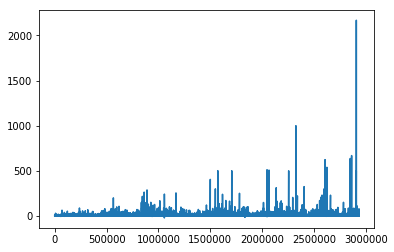

In [38]:
sales_train['item_cnt_day'].plot()
sales_train['item_cnt_day'].describe()

It's good to remove these two spikes

5999.0

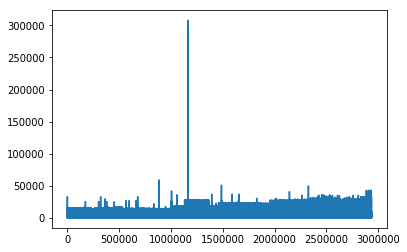

In [39]:
sales_train['item_price'].plot()
sales_train['item_price'].quantile(0.99)

In [40]:
sales_train['item_price'].describe()

count    2.935849e+06
mean     8.908532e+02
std      1.729800e+03
min     -1.000000e+00
25%      2.490000e+02
50%      3.990000e+02
75%      9.990000e+02
max      3.079800e+05
Name: item_price, dtype: float64

It's good to remove the unque spikes

In [41]:
sales_train = sales_train[sales_train['item_cnt_day']<1000]
sales_train = sales_train[sales_train['item_price']<5999]

test

In [42]:
test["date_block_num"] = 34
sales_train = pd.concat([sales_train, test], ignore_index=True, sort=False, keys=['date_block_num','shop_id','item_id'])
sales_train.fillna(0, inplace=True)

Data encoding 

In [44]:
block_shop_item = sales_train[['date_block_num','shop_id','item_id']].drop_duplicates()
sales_train_enc = sales_train.groupby(['date_block_num', 'shop_id', 'item_id']).agg({'item_cnt_day':'sum','item_price':np.mean}).reset_index()
sales_train_enc = pd.merge(block_shop_item, sales_train_enc,on=['date_block_num', 'shop_id', 'item_id'],how='left').fillna(0)
sales_train_enc = pd.merge(sales_train_enc, items, on='item_id',how='left')

to_encode = [['item_id', 'date_block_num'], ['shop_id', 'date_block_num'], ['item_category_id', 'date_block_num']]
to_encode_name = ['item_block', 'shop_block', 'cat_block']
sales_train2 = sales_train.copy()
for enc, enc_ in zip(to_encode, to_encode_name):
    group = sales_train.groupby(enc).agg({'item_price': np.mean, 'item_cnt_day': [sum, np.mean]}).reset_index()
    group.columns = [col[0] for col in group.columns[0:-3] ] + [enc_+'_'+col[0]+'_'+col[1] for col in group.columns[-3:] ]
    sales_train_enc = sales_train_enc.merge(group, on = enc, how = 'left')

Faetures laging 

In [46]:
to_lag = ['item_cnt_day', 'item_block_item_price_mean', 'item_block_item_cnt_day_sum',
       'item_block_item_cnt_day_mean', 'shop_block_item_price_mean',
       'shop_block_item_cnt_day_sum', 'shop_block_item_cnt_day_mean',
       'cat_block_item_price_mean', 'cat_block_item_cnt_day_sum','cat_block_item_cnt_day_mean']

lags = [1, 2, 3, 6]
for lag in lags:
    sales_train_enc_lag = sales_train_enc.copy()
    sales_train_enc_lag['date_block_num'] += lag
    sales_train_enc_lag = sales_train_enc_lag[['date_block_num','shop_id','item_id']+to_lag]
    sales_train_enc_lag.columns = ['date_block_num','shop_id','item_id']+ [lagged+'_lag_'+str(lag) for lagged in to_lag]
    sales_train_enc = pd.merge(sales_train_enc, sales_train_enc_lag, on=['date_block_num','shop_id','item_id'] ,how='left')

Train test splitting

In [47]:
train = sales_train_enc.astype(np.float16).fillna(0)

X_train = train[train['date_block_num'] < 33].drop(['item_cnt_day'], axis=1)
y_train = train[train['date_block_num'] < 33]['item_cnt_day']
X_val = train[train['date_block_num'] == 33].drop(['item_cnt_day'], axis=1)
y_val = train[train['date_block_num'] == 33]['item_cnt_day']
X_test = train[train['date_block_num'] == 34].drop(['item_cnt_day'], axis=1)

Random Foreset regression model fitting

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    bootstrap=True,
    max_depth=25,
    max_features=3,
    min_samples_leaf=5,
    min_samples_split=15,
    n_estimators=201,
    random_state=42,
    verbose=1,
    n_jobs=-1
)


rf.fit(X_train, y_train)





y_pred = rf.predict(X_val).clip(0, 20)
y_test = rf.predict(X_test).clip(0, 20)
submission = pd.DataFrame({
    "ID": test.index,
    "item_cnt_month": y_test
})
submission.to_csv('submission.csv', index=False)